# Custom modules

In [1]:
import os
import sys
sys.path.insert(1, '/home/mauricio/code/mcr/')

from mcr.ml.model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split, sample_report, split_report, sample_split_report
from mcr.ml import get_dummies_indices, reverse_dummies
from mcr.util import size, glimpse

# Standard data science modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')

# Loading data

Sign up for an account on [DrivenData](http://www.drivendata.org/)  
Join the [Box-plots for education competition](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/)  
Download the competition datasets named `TrainingData.csv` and `TestData.csv`

In [3]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

# Shuffling data

In machine learning theory, i.i.d. assumption is often made for training datasets to imply that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

To ensure observations are independent and don't follow any predefined sequence, the dataset is shuffled.

That's important when using the class `sklearn.model_selection.GridSearchCV` with k-fold cross-validation which doesn't resample the dataset as per the underlying class `sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)` doesn't shuffle data by default and that could lead to biased folds.

In [4]:
#df = df.sample(frac=1, replace=False, random_state=1)

# Encoding labels as category types

In [5]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
FEATURES = [feature for feature in df.columns if feature not in LABELS]
print('Memory before enconding: {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after enconding : {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))

Memory before enconding: 79.4 MiB (548.5 MiB deep)
Memory after enconding : 55.4 MiB (313.0 MiB deep)


# Frequency of classes per label

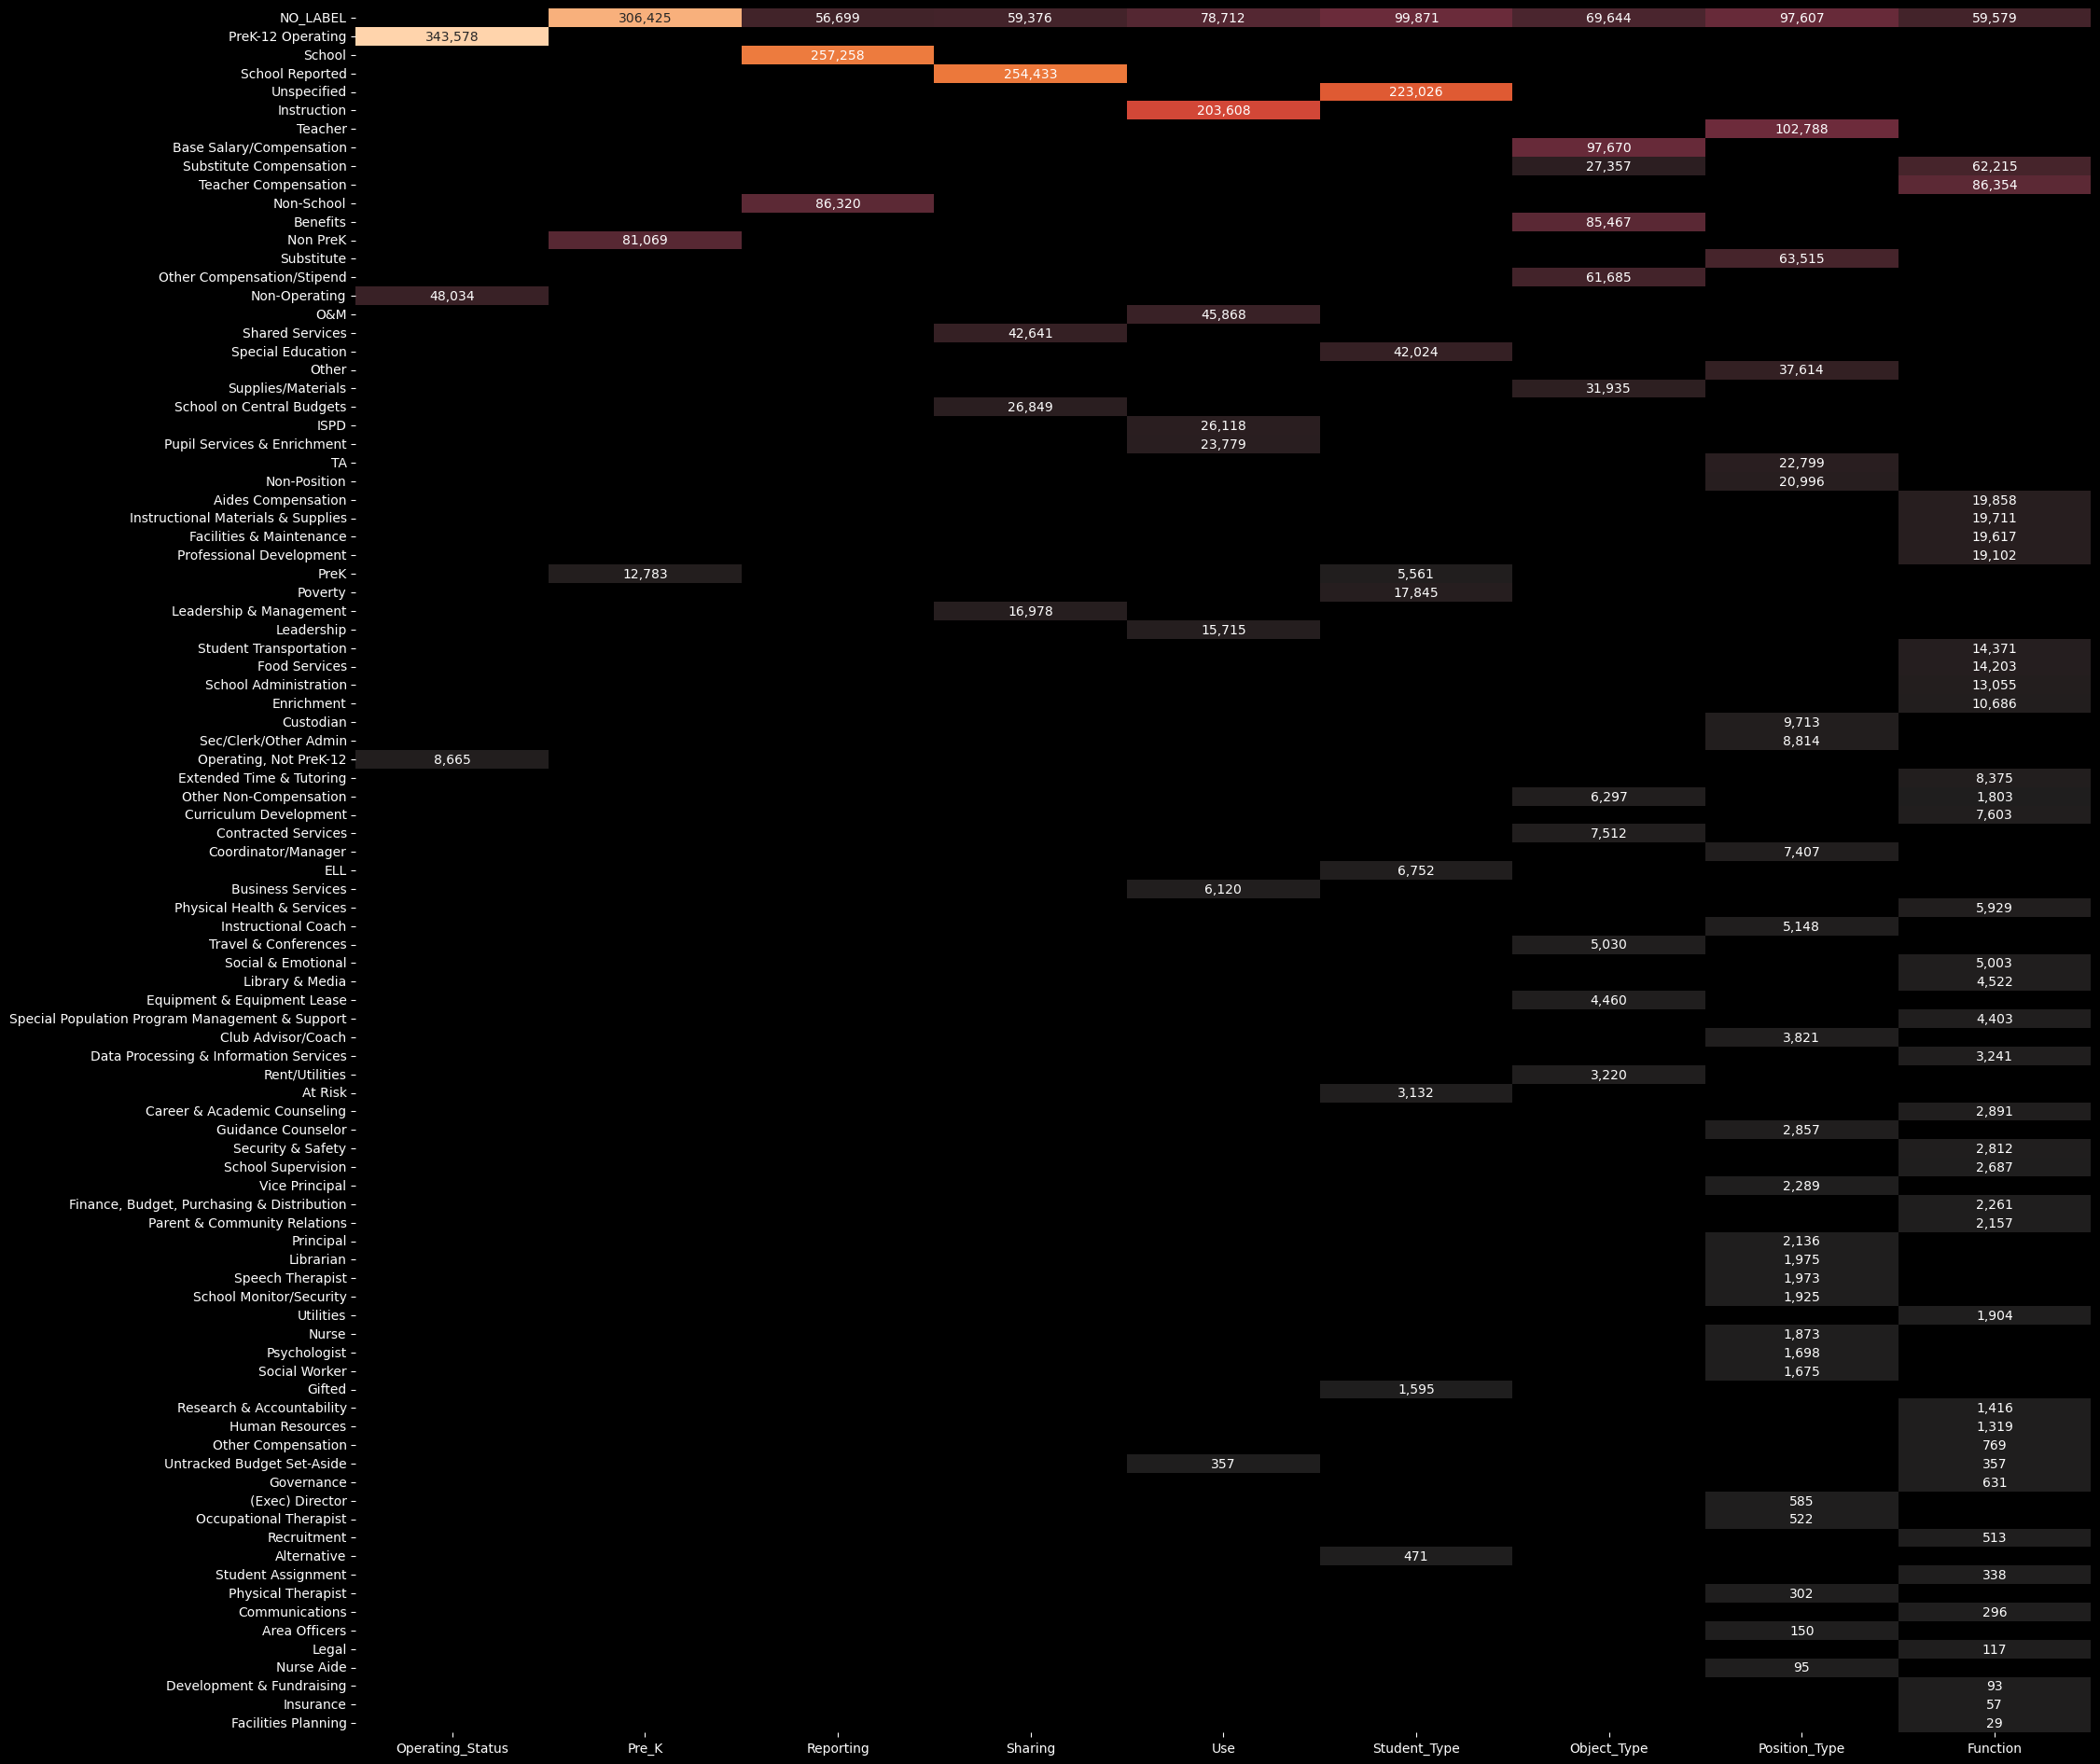

In [6]:
col_idx = df[LABELS].apply(lambda x: x.value_counts()).count().sort_values(ascending=True).index
row_idx = df[LABELS].apply(lambda x: x.value_counts()).sum(axis=1).sort_values(ascending=False).index
plt.figure(figsize=(24,24))
sns.heatmap(df[col_idx].apply(lambda x: x.value_counts()).loc[row_idx], annot=True, fmt=',.0f', center=0, cbar=False)
plt.show()

# Frequency of labels

In [7]:
df[LABELS].value_counts().to_frame('value_counts').sort_values('value_counts', ascending=False)

value_counts
Function                Object_Type              Operating_Status  Position_Type Pre_K    Reporting  Sharing                 Student_Type Use                            
NO_LABEL                NO_LABEL                 Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL                NO_LABEL     NO_LABEL                  48034
Teacher Compensation    Benefits                 PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified  Instruction               22169
Substitute Compensation Base Salary/Compensation PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified  Instruction               16130
                        Benefits                 PreK-12 Operating Substitute    NO_LABEL School     School Reported         Unspecified  Instruction               14110
Teacher Compensation    Base Salary/Compensation PreK-12 Operating Teacher       NO_LABEL School     School Reported         Unspecified  Instruction               13551
...                                                                                                                                                                   ...
Insurance               Contracted Services      PreK-12 Operating NO_LABEL      NO_LABEL Non-School Leadership & Management Unspecified  Business Services             1
                                                                                 Non PreK Non-School Leadership & Management Unspecified  Business Services             1
                        Other Non-Compensation   PreK-12 Operating NO_LABEL      Non PreK Non-School Leadership & Management Unspecified  Business Services             1
                                                                                                     Shared Services         Unspecified  Business Services             1
Utilities               Supplies/Materials       PreK-12 Operating Non-Position  NO_LABEL Non-School Shared Services         Unspecified  O&M                           1

[5489 rows x 1 columns]

# Converting labels in dummy variables

In [8]:
# Converting labels in dummy variables
y = pd.get_dummies(df[LABELS], prefix_sep='__')
y.info(memory_usage='deep')
y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 42.8 MB


,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
364634,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109283,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
102430,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
413949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
433672,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


# Frequency of dummy variables

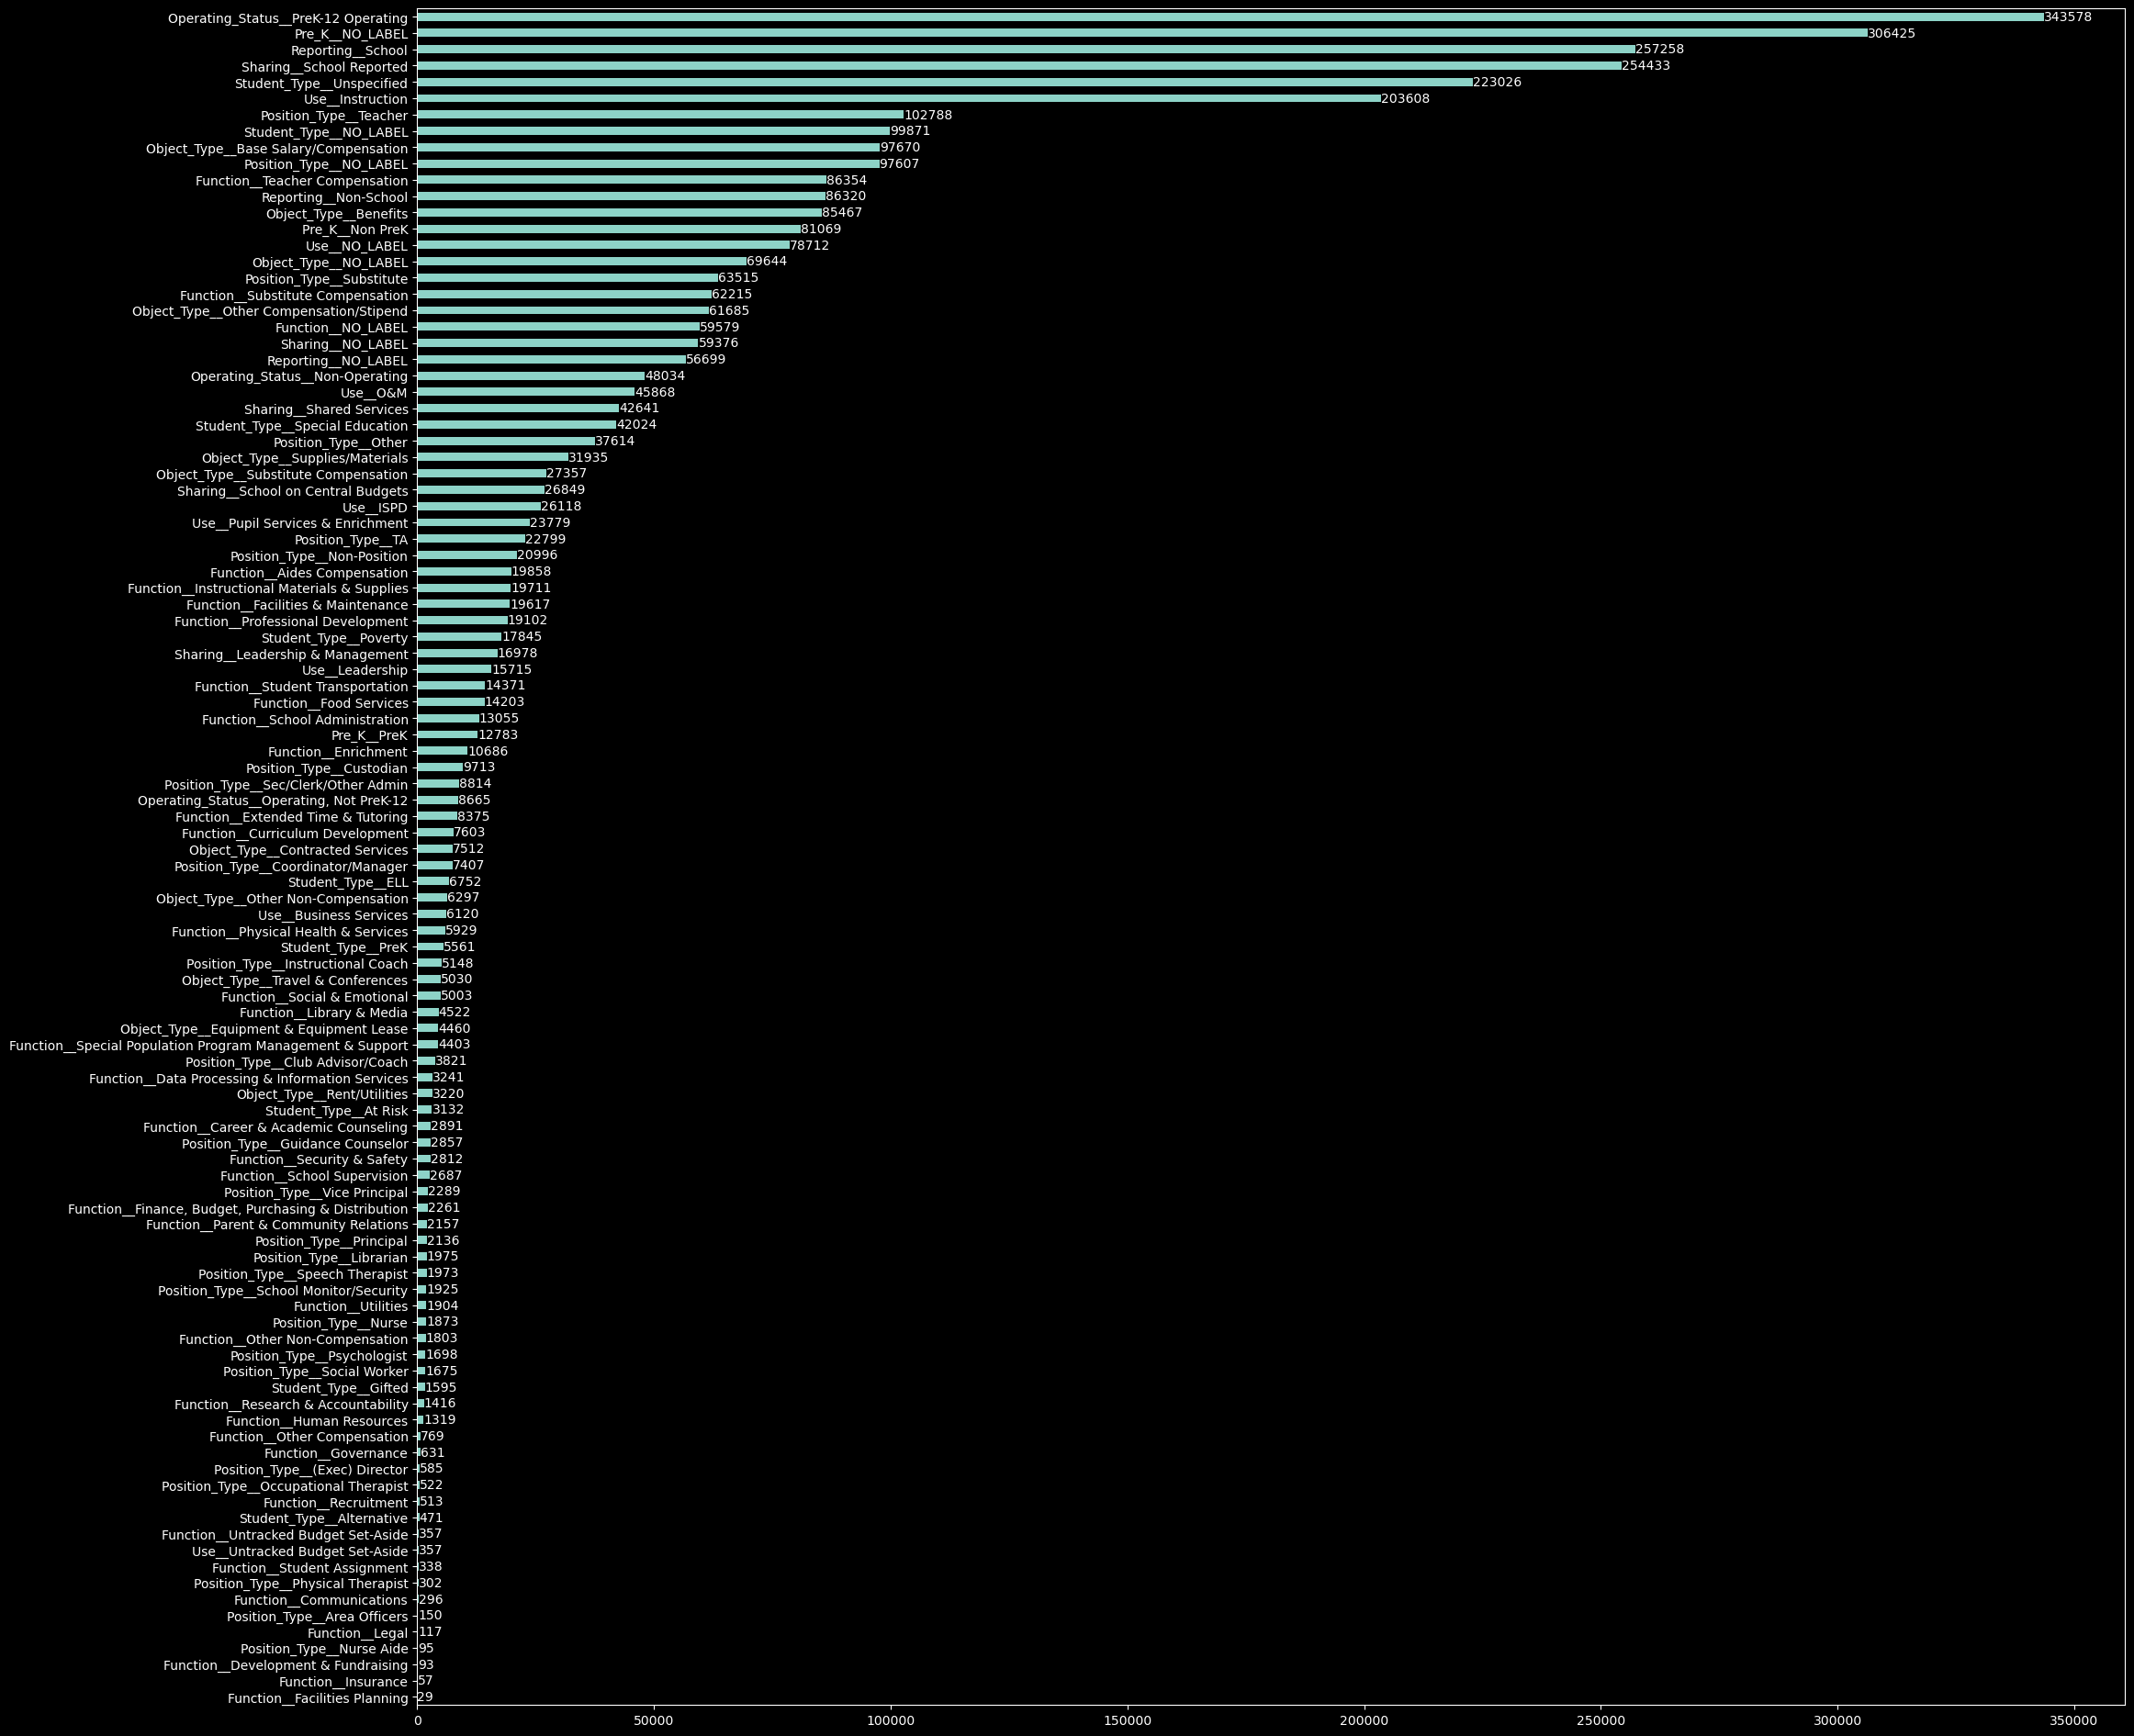

In [9]:
plt.figure(figsize=(24,24))
ax = y.sum().sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.show()

# Number of classes (ones)

In [10]:
y.sum().sum()

3602493

# Test 0: Imbalanced 50/50 split using sklearn's train_test_split()

Train size: 200138
Test size : 200139


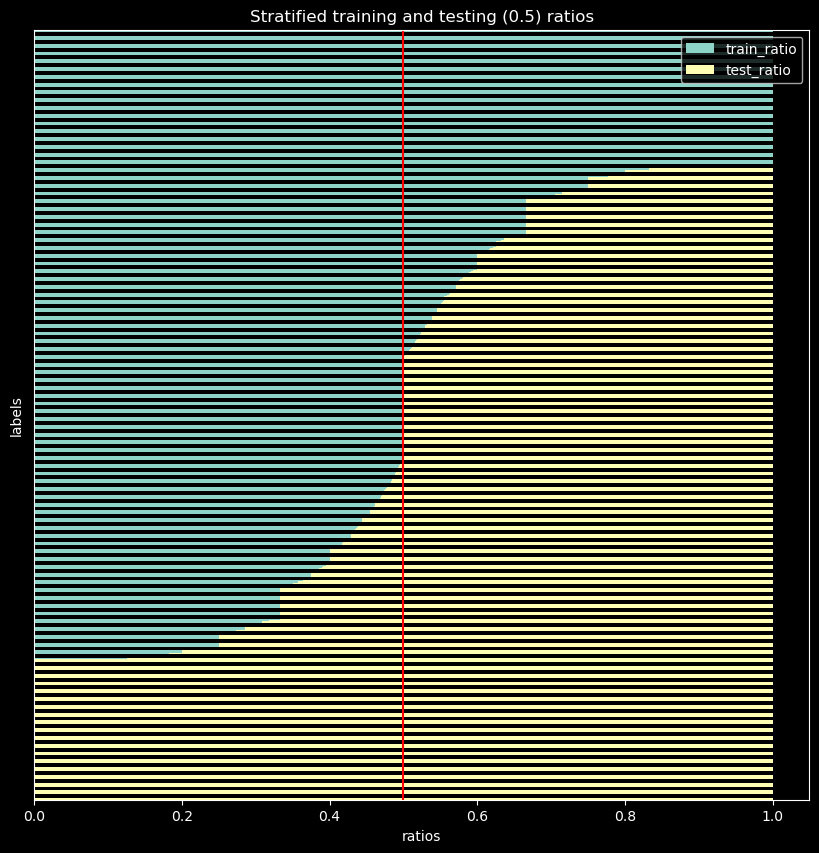

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = .5, random_state=1, stratify=None)
print('Train size:', y_train.shape[0])
print('Test size :', y_test.shape[0])
# split_report(y, y_train, y_test, figsize=(10,10))
_ = split_report(y, y_train, y_test, figsize=(10,10))

# Test 1: trying to stratify split using sklearn's train_test_split()

In [12]:
from sklearn.model_selection import train_test_split
try:
    X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = 0.5, random_state=1, stratify=y)
except ValueError as err:
    print('ValueError:', err)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


As pointed out in **_Groups of labels with less than 2 samples (unstratifiable)_**, the y population has class groups with less than 2 observations, thefore, the standard sklearn's `train_test_split()` won't work because of those cases.

# Test 2: stratifying .5 sample using multi_train_test_split()

Sample size: 200138


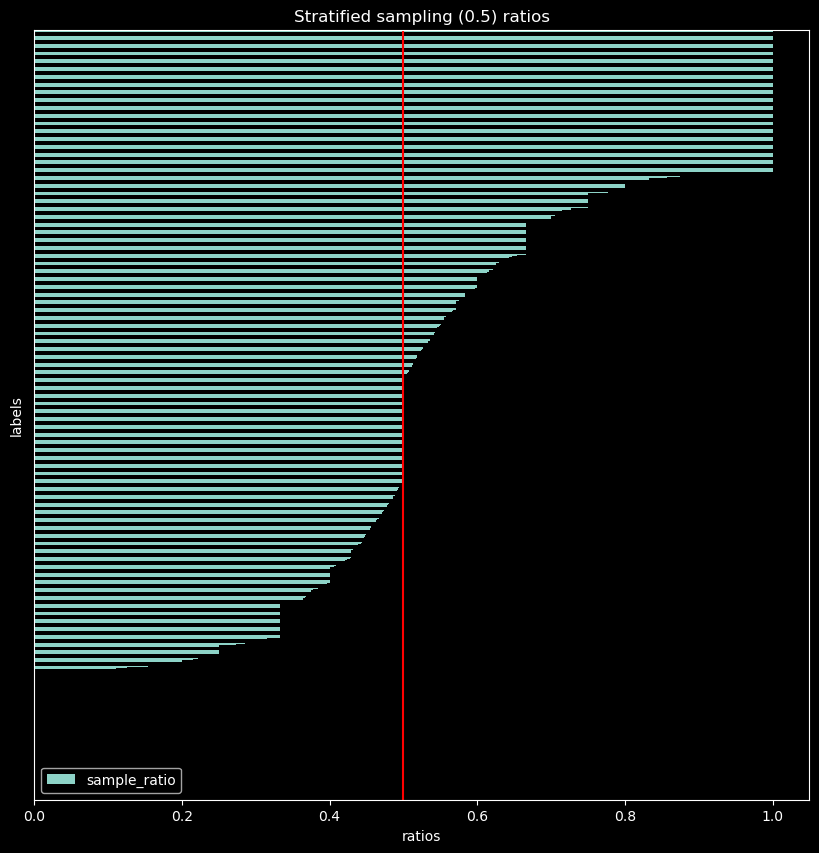

In [13]:
sampling = multilabel_sample_dataframe(df, y, size=0.5, min_count=29, seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
print('Sample size:', sampling.shape[0])
_ = sample_report(y, dummy_labels, figsize=(10,10))

# Test 3: Stratifying 50/50 split using multi_train_test_split()

Train size: 200139
Test size : 200138


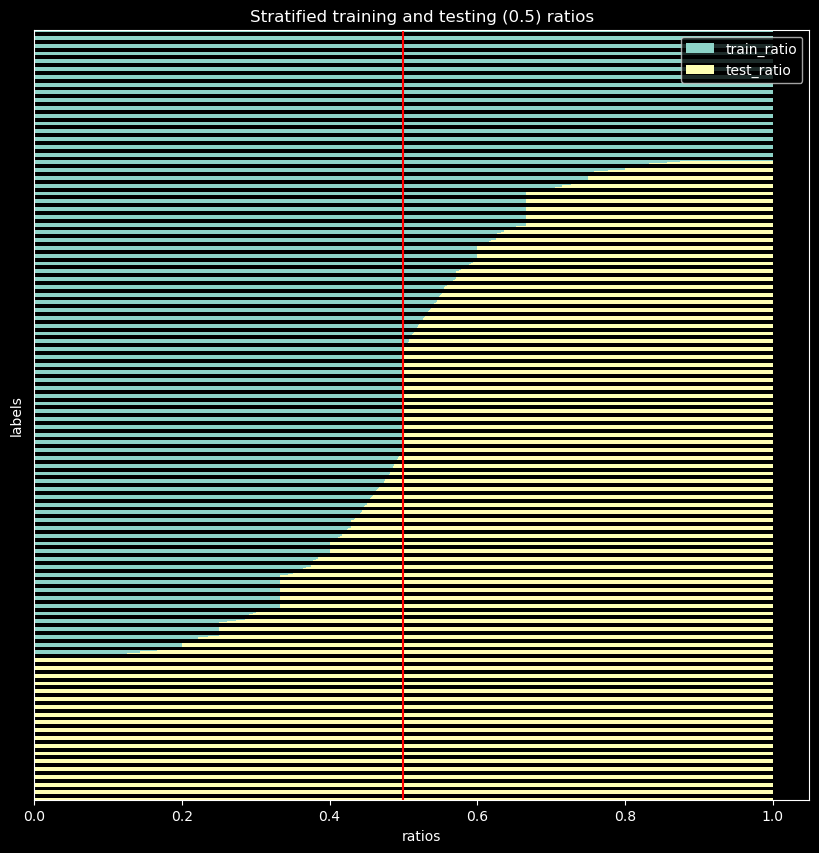

In [14]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], y, size=0.5, min_count=29, seed=1)
print('Train size:', y_train.shape[0])
print('Test size :', y_test.shape[0])
_ = split_report(y, y_train, y_test, figsize=(10,10))

# Test 4: Stratifying 90/10 split of a stratified 1.0 sample using multi_train_test_split()

## Stratified sample

Sample size: 400277


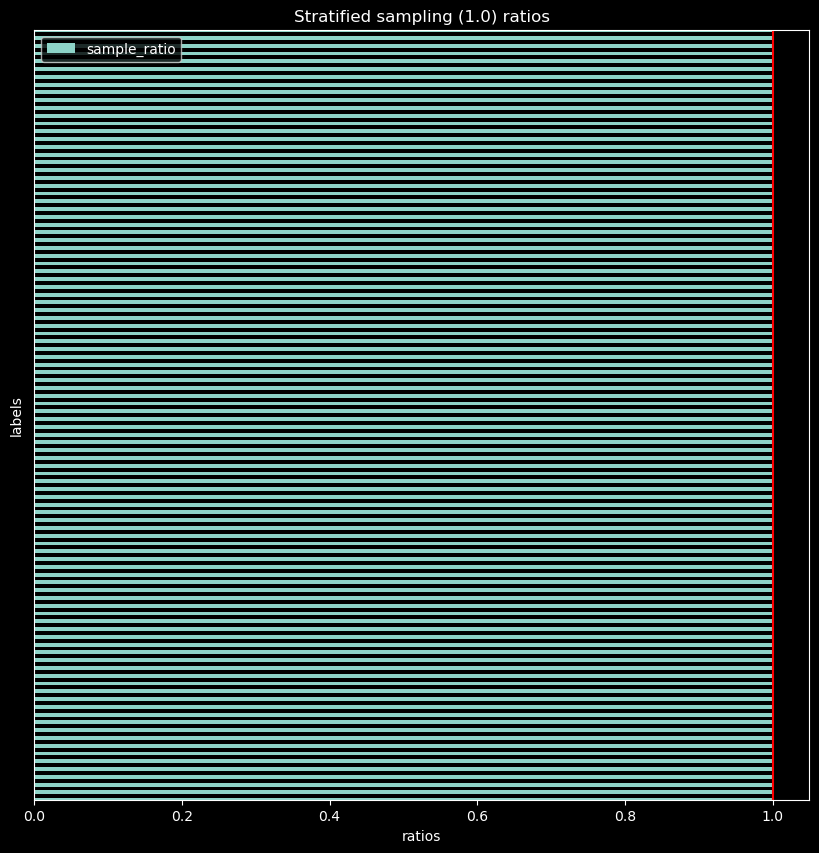

In [15]:
sampling = multilabel_sample_dataframe(df, y, size=1.0, min_count=19, seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
print('Sample size:', sampling.shape[0])
_ = sample_report(y, dummy_labels, figsize=(10,10))

## Stratified split of the stratified sample

Sample size: 400277
Train size : 360250
Test size  : 40027


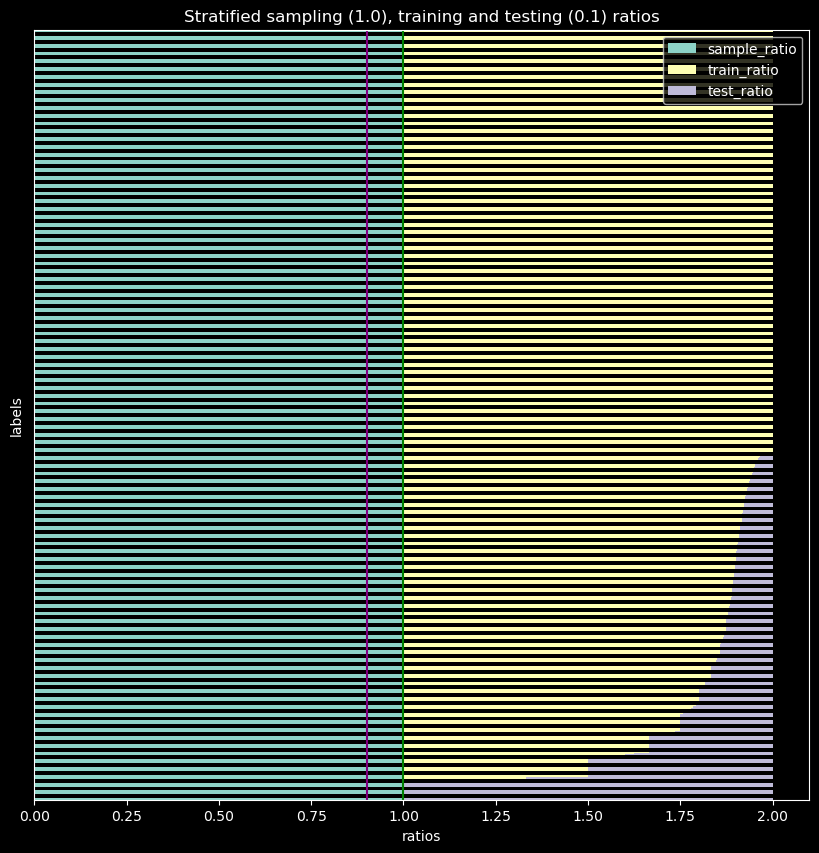

In [16]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels, size=0.1, min_count=3, seed=1)
print('Sample size:', sampling.shape[0])
print('Train size :', y_train.shape[0])
print('Test size  :', y_test.shape[0])
_ = sample_split_report(y, dummy_labels, y_train, y_test, figsize=(10,10))

Here we see that some testing labels are missing after splitting.  
It's required to simultaneously optimize the `size` and `min_count` parameters on either `multilabel_sample_dataframe` and `multilabel_train_test_split`, thus, balancing the stratification the best possible to achieve the best ratio.

# Optimize sampling and splitting parameters

Run the script `optimize-sample-split.py` to prepare data for analysis

In [17]:
# ! python optimize-sample-split.py

In [18]:
import pickle
if not os.path.isfile('/data/drivendata/optimize-sample-split.pkl'):
    print('Please run the optimize-sample-split.py')
else:
    with open('/data/drivendata/optimize-sample-split.pkl', 'rb') as f:
        results = pickle.load(f)
        display(glimpse(results))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100799 entries, 0 to 100798
Columns: 10 entries, sample_size to test_ratio
dtypes: float64(5), object(5)
memory usage: 21.0 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,sample_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
1,sample_min_count,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
2,sample_ratio,100799,0.0,float64,541,"[0.06675592536155764, 0.07295573178258284, 0.0..."
3,sample_size,100799,0.0,float64,19,"[0.01, 0.01999999999999999, 0.03, 0.0399999999..."
4,test_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
5,test_min_count,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
6,test_ratio,100799,0.0,float64,100538,"[0.024211710155202838, 0.027255346978995582, 0..."
7,test_size,100799,0.0,float64,9,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,..."
8,train_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
9,train_ratio,100799,0.0,float64,100538,"[0.016213462665645117, 0.017129853111320717, 0..."


## Metric

Best sample, train, test ratios

In [19]:
metrics = ['sample_size', 'sample_ratio', 'train_ratio', 'test_ratio']
display(results.sort_values(metrics, ascending=False).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics))
results.sort_values(metrics, ascending=False).tail(3).style.set_properties(**{'background-color': 'red'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
5133,1.000000,19,29,1.000000,0.100000,3,22,7,0.927843,0.217250
7023,1.000000,26,29,1.000000,0.100000,3,22,7,0.927512,0.215472
6212,1.000000,23,29,1.000000,0.100000,2,24,5,0.927289,0.214517


,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
97582,0.010000,0,0,0.066756,0.700000,0,0,0,0.036745,0.060474
97583,0.010000,0,0,0.066756,0.800000,0,0,0,0.035214,0.061512
97584,0.010000,0,0,0.066756,0.900000,0,0,0,0.017565,0.066583


# Best parameters selection

* To allow cross-validation of 5 folds the minimal class frequency must be 5 for the training set and 1 for the test set.

In [20]:
k = 5
k_fold_condition = (results.train_lessfreq >= k) & (results.test_lessfreq >= 1) #& (results.train_lessfreq >= results.test_lessfreq)

* For begining the model, the selection should be:
    * The smallest sample size (e.g. 0.1)
    * The smallest test size (e.g. 0.1)
    * The best train ratios
* For finishing the model, the parameter set should have:
    * The full dataset
    * The smallest test size (e.g. 0.1)
    * best train ratios

## For 1% sample

In [21]:
ascending = [True, False, False, False]
results[k_fold_condition].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
100459,0.010000,28,28,0.145545,0.100000,0,22,1,0.139017,0.068591
100461,0.010000,28,28,0.145545,0.100000,2,21,3,0.137327,0.074610
100460,0.010000,28,28,0.145545,0.100000,1,21,1,0.135156,0.093377


## 10% sample

In [22]:
results[k_fold_condition & (results.sample_size>=0.1)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
62946,0.100000,28,28,0.250124,0.100000,0,23,1,0.232157,0.092049
62947,0.100000,28,28,0.250124,0.100000,1,23,2,0.230817,0.089238
62949,0.100000,28,28,0.250124,0.100000,3,23,5,0.230547,0.095275


## 20% sample

In [23]:
results[k_fold_condition & (results.sample_size>=0.19)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
58365,0.200000,28,28,0.357271,0.100000,0,26,1,0.336651,0.095655
58366,0.200000,28,28,0.357271,0.100000,1,26,2,0.334249,0.099641
58367,0.200000,28,28,0.357271,0.100000,2,25,3,0.333678,0.106211


## 30% sample

In [24]:
results[k_fold_condition & (results.sample_size>=0.2)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
53391,0.300000,28,28,0.450148,0.100000,3,24,4,0.420175,0.121831
53389,0.300000,28,28,0.450148,0.100000,1,27,1,0.419030,0.125206
53390,0.300000,28,28,0.450148,0.100000,2,21,4,0.418754,0.122319


## 50% sample

In [25]:
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) & (results.train_lessfreq > results.test_lessfreq) & (results.sample_size==0.5)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
42507,0.500000,29,29,0.620021,0.100000,0,27,2,0.578020,0.144577
42510,0.500000,29,29,0.620021,0.100000,3,23,6,0.576383,0.157208
42509,0.500000,29,29,0.620021,0.100000,2,22,6,0.576330,0.153578


## 60% sample

In [26]:
results[k_fold_condition & (results.sample_size==0.6)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
34070,0.600000,20,26,0.699567,0.100000,5,18,8,0.648227,0.161996
34067,0.600000,20,26,0.699567,0.100000,2,23,3,0.647990,0.175253
34065,0.600000,20,26,0.699567,0.100000,0,25,1,0.647182,0.166185


## 80% sample

In [27]:
results[k_fold_condition & (results.sample_size>=0.8)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
21726,0.800000,25,29,0.854414,0.100000,0,28,1,0.793677,0.192264
21727,0.800000,25,29,0.854414,0.100000,1,24,5,0.792206,0.191422
21729,0.800000,25,29,0.854414,0.100000,3,25,4,0.792142,0.202101


## For finishing the model

In [28]:
ascending = [False, False, False, False]
results[k_fold_condition
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
5133,1.000000,19,29,1.000000,0.100000,3,22,7,0.927843,0.217250
7023,1.000000,26,29,1.000000,0.100000,3,22,7,0.927512,0.215472
6212,1.000000,23,29,1.000000,0.100000,2,24,5,0.927289,0.214517
